In [ ]:
%pip install nibabel
%pip install opencv-python
%pip install albumentations
%pip install segmentation_models_pytorch 



import os
import torch
from torch.utils.data import DataLoader
from src.dataset import ISLESDataset3D
from src.augmentations import get_train_augmentations
from src.model import get_unet
from src.ensemble import load_ensemble, ensemble_predict
from src.utils import dice_score, plot_sample
import torch.nn.functional as F
import warnings

def safe_unsqueeze_mask(y):
    # Ensure mask is [B, 1, D, H, W]
    if y.ndim == 4:
        y = y.unsqueeze(1)
    elif y.ndim == 5 and y.shape[1] != 1:
        # If mask has extra channels, take the first
        y = y[:, :1, ...]
    elif y.ndim < 4:
        raise ValueError(f"Mask shape too small: {y.shape}")
    return y

def safe_pad_or_crop(x, target_shape):
    # Accepts [B, C, D, H, W] or [B, D, H, W] or [C, D, H, W]
    if x.ndim == 4:
        x = x.unsqueeze(0)  # Add batch dim if missing
    if x.ndim == 5:
        _, _, D, H, W = x.shape
        tD, tH, tW = target_shape
        pad_d = max(tD - D, 0)
        pad_h = max(tH - H, 0)
        pad_w = max(tW - W, 0)
        x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
        x = x[:, :, :tD, :tH, :tW]
    else:
        raise ValueError(f"Input shape not supported: {x.shape}")
    return x

print(f"Imports done")
# 1. Set up paths and parameters
DATA_DIR = "../data"  # or your actual data folder path
N_MODELS = 3
EPOCHS = 2
BATCH_SIZE = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Prepare dataset and dataloader",DEVICE)
def pad_collate(batch):
    xs, ys = zip(*batch)
    # Find max height, width, depth in this batch
    max_h = max(x.shape[-3] for x in xs)
    max_w = max(x.shape[-2] for x in xs)
    max_d = max(x.shape[-1] for x in xs)
    xs_padded = []
    ys_padded = []
    for x, y in zip(xs, ys):
        pad_h = max_h - x.shape[-3]
        pad_w = max_w - x.shape[-2]
        pad_d = max_d - x.shape[-1]
        # Pad as (left, right, top, bottom, front, back)
        # F.pad uses (D1, D2, H1, H2, W1, W2) for 5D tensors
        # For 4D tensors: (N, C, H, W, D) or (C, H, W, D)
        # Here, x is likely (C, H, W, D)
        x_padded = F.pad(x, (0, pad_d, 0, pad_w, 0, pad_h))
        y_padded = F.pad(y, (0, pad_d, 0, pad_w, 0, pad_h))
        xs_padded.append(x_padded)
        ys_padded.append(y_padded)
    xs_padded = torch.stack(xs_padded)
    ys_padded = torch.stack(ys_padded)
    return xs_padded, ys_padded

def pad_or_crop_to_shape(x, target_shape):
    # x: [B, C, D, H, W]
    _, _, D, H, W = x.shape
    tD, tH, tW = target_shape
    # Pad
    pad_d = max(tD - D, 0)
    pad_h = max(tH - H, 0)
    pad_w = max(tW - W, 0)
    x = F.pad(x, [0, pad_w, 0, pad_h, 0, pad_d])
    # Crop
    x = x[:, :, :tD, :tH, :tW]
    return x

train_dataset = ISLESDataset3D(
    root_dir=DATA_DIR)
sample_x, sample_y = train_dataset[0]
print("Sample mask unique:", torch.unique(sample_y))
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=pad_collate
)
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of batches in DataLoader: {len(train_loader)}")

print(f"#Train multiple base models for ensemble")
for i in range(N_MODELS): 
    model = get_unet(in_channels=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(EPOCHS):
        model.train()
        print(f"Training model {i}, epoch {epoch+1}/{EPOCHS}")
       # ...existing code...
    # In your training loop:
    for batch_idx, (x, y) in enumerate(train_loader):
        target_shape = (128, 128, 64)
        # Ensure correct dims and type
        if x.ndim == 4:
            x = x.unsqueeze(0)
        if x.ndim == 5 and x.shape[1] > 2:
            x = x[:, :2, ...]
        x = safe_pad_or_crop(x, target_shape)
        x = x.to(DEVICE, dtype=torch.float)
        # Mask handling
        y = safe_unsqueeze_mask(y)
        y = safe_pad_or_crop(y, target_shape)
        y = y.to(DEVICE, dtype=torch.float)
        y = y.clamp(0, 1)  # Ensure mask is binary/float

        print("x shape:", x.shape)
        print("y shape:", y.shape)      # [B, 2, H, W]
        # No further slicing needed!  # [B, 2, H, W]

        # For y (mask), shape: [B, D, H, W]
        optimizer.zero_grad()
        out = model(x)
        bce = torch.nn.BCELoss()
        loss = 0.5 * bce(out, y) + 0.5 * (1 - dice_score(out, y))
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"  Model {i} Epoch {epoch+1} Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}")
# ...existing code...
    torch.save(model.state_dict(), f"base_model_{i}.pth")
    print(f"Saved base_model_{i}.pth")

print(f"#Load ensemble models")
model_paths = [f"base_model_{i}.pth" for i in range(N_MODELS)]
ensemble_models = load_ensemble(model_paths, DEVICE)

print(f"#Ensemble prediction on a batch")
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))
x = x.to(DEVICE, dtype=torch.float)
y = y.to(DEVICE, dtype=torch.float)
if x.shape[1] > 2:
    x = x[:, :2, ...]  # Ensure only 2 channels
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)  # Use full 3D volume

# For visualization, take a middle slice
mid_slice = x.shape[2] // 2  # D axis
x_vis = x[:, :, mid_slice, :, :]  # [B, 2, H, W]
y_vis = y[:, :, mid_slice, :, :] if y.ndim == 5 else y[:, mid_slice, :, :]
final_mask_vis = final_mask[:, 0, mid_slice, :, :]  # [B, H, W]
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)

print(f"#Evaluate and visualize")
for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    print(f"Dice score (ensemble): {dice_score(final_mask[i], y[i])}")
    plot_sample(x[i].cpu().squeeze(), y[i].cpu(), final_mask[i].cpu().squeeze(), channel=0)  # DWI
    continue





[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports done
Prepare dataset and dataloader cpu
entering 3D samples
Total 3D samples: 248
Sample mask unique: tensor([0., 1.])
Number of samples in dataset: 248
Number of batches in DataLoader: 83
#Train multiple base models for ensemble
Training model 0, epoch 1/2
Training model 0, epoch 2/2
x shape: torch.Size([3, 2, 128, 128, 64])
y shape: torch.Size([3, 1, 128, 128, 64])
skip shape: torch.Size([3, 256, 16, 16, 8])
x shape: torch.Size([3, 256, 16, 16, 8])
skip shape: torch.Size([3, 128, 32, 32, 16])
x shape: torch.Size([3, 128, 32, 32, 16])
skip shape: torch.Size([3, 64, 64, 64, 32])
x shape: torch.Size([3, 64, 64, 64, 32])
skip shape: torch.Size([3, 32, 128, 128, 64])
x shape: torch.Size([3, 32, 128, 128, 64])
  Model 0 Epoch 2 Batch 0/83 Loss: 0.9294
x shape: torch.Size([3, 2, 128, 128, 64])
y shape: torch.Size([3, 1, 128, 128, 64])
skip shape: torch.Size([3, 256, 16, 16, 8])
x shape: torch.Size([3, 256, 16, 16, 8])
skip shape: torch.Size([3, 128, 32, 32, 16])
x shape: torch.Size(

RuntimeError: Given groups=1, weight of size [32, 2, 3, 3, 3], expected input[1, 3, 2, 128, 128] to have 2 channels, but got 3 channels instead

#Load ensemble models
#Ensemble prediction on a batch
Input min/max: tensor(0.) tensor(1849.5935)
Mask unique values: tensor([0., 1.])
skip shape: torch.Size([3, 256, 24, 24, 9])
x shape: torch.Size([3, 256, 24, 24, 9])
skip shape: torch.Size([3, 128, 48, 48, 18])
x shape: torch.Size([3, 128, 48, 48, 18])
skip shape: torch.Size([3, 64, 96, 96, 36])
x shape: torch.Size([3, 64, 96, 96, 36])
skip shape: torch.Size([3, 32, 192, 192, 73])
x shape: torch.Size([3, 32, 192, 192, 73])
skip shape: torch.Size([3, 256, 24, 24, 9])
x shape: torch.Size([3, 256, 24, 24, 9])
skip shape: torch.Size([3, 128, 48, 48, 18])
x shape: torch.Size([3, 128, 48, 48, 18])
skip shape: torch.Size([3, 64, 96, 96, 36])
x shape: torch.Size([3, 64, 96, 96, 36])
skip shape: torch.Size([3, 32, 192, 192, 73])
x shape: torch.Size([3, 32, 192, 192, 73])
skip shape: torch.Size([3, 256, 24, 24, 9])
x shape: torch.Size([3, 256, 24, 24, 9])
skip shape: torch.Size([3, 128, 48, 48, 18])
x shape: torch.Size([3, 128, 48, 48, 18])
s

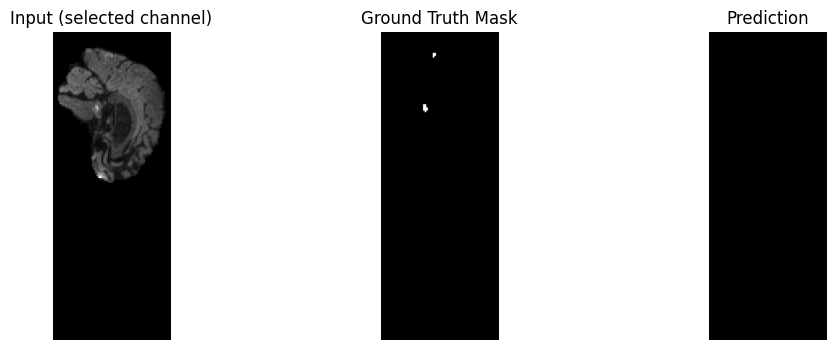

Sample 1: slice 39, input min/max: 0.0 222.00186157226562
Sample 1: mask unique: tensor([0., 1.])
Sample 1: pred unique: tensor([0., 1.])


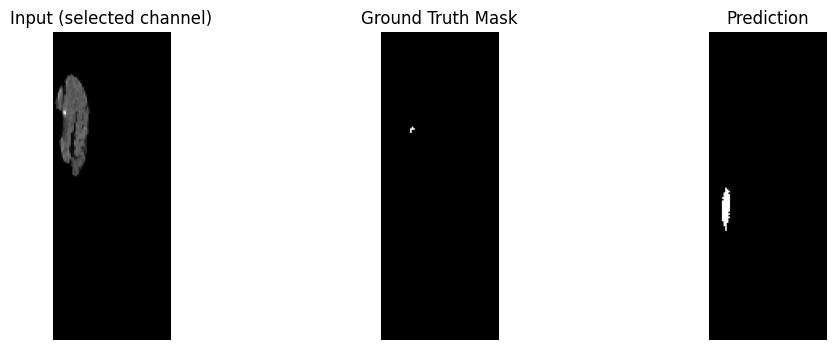

Sample 2: slice 64, input min/max: 0.0 861.9944458007812
Sample 2: mask unique: tensor([0., 1.])
Sample 2: pred unique: tensor([0., 1.])


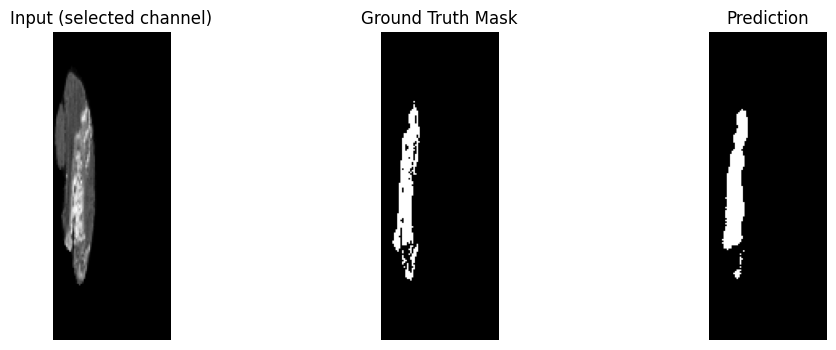

In [5]:

print(f"#Load ensemble models")
model_paths = [f"base_model_{i}.pth" for i in range(N_MODELS)]
ensemble_models = load_ensemble(model_paths, DEVICE)

print(f"#Ensemble prediction on a batch")
x, y = next(iter(train_loader))
print("Input min/max:", x.min(), x.max())
print("Mask unique values:", torch.unique(y))
x = x.to(DEVICE, dtype=torch.float)
y = y.to(DEVICE, dtype=torch.float)
if x.shape[1] > 2:
    x = x[:, :2, ...]  # Ensure only 2 channels
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)  # Use full 3D volume

# For visualization, take a middle slice
mid_slice = x.shape[2] // 2  # D axis
x_vis = x[:, :, mid_slice, :, :]  # [B, 2, H, W]
y_vis = y[:, :, mid_slice, :, :] if y.ndim == 5 else y[:, mid_slice, :, :]
final_mask_vis = final_mask[:, 0, mid_slice, :, :]  # [B, H, W]
final_mask, averaged_probs = ensemble_predict(ensemble_models, x)

print(f"#Evaluate and visualize")
for i in range(min(3, x.shape[0])):  # Show up to 3 samples
    # Find a slice with nonzero mask, else use middle
    mask_3d = y[i, 0] if y.ndim == 5 else y[i]
    nonzero_slices = torch.where(mask_3d.sum(dim=(-1, -2)) > 0)[0]
    if len(nonzero_slices) > 0:
        slice_idx = int(nonzero_slices[len(nonzero_slices)//2])
    else:
        slice_idx = x.shape[2] // 2  # fallback to middle

    print(f"Sample {i}: slice {slice_idx}, input min/max:", x[i, 0, slice_idx].min().item(), x[i, 0, slice_idx].max().item())
    print(f"Sample {i}: mask unique:", torch.unique(mask_3d[slice_idx]))
    print(f"Sample {i}: pred unique:", torch.unique(final_mask[i, 0, slice_idx]))

    x_slice = x[i, :, slice_idx, :, :].cpu().squeeze()  # [C, H, W] or [H, W]
    y_slice = mask_3d[slice_idx].cpu().squeeze()
    mask_slice = final_mask[i, 0, slice_idx, :, :].cpu().squeeze()
    plot_sample(x_slice, y_slice, mask_slice, channel=0)  # DWI
    continue


